In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io as io
from skimage import feature
from skimage.transform import resize
from sklearn.feature_selection import VarianceThreshold
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skimage.filters import gabor
from skimage.feature import corner_fast, corner_peaks, corner_harris
import sys
import os
sys.path.append('../')
import helpers.histogram_classifier as hc

In [2]:
def sub_grid(image, size=32):
    """
    Split an image into a grid of non-overlapping square boxes, and return each box in turn
    :params image: image as numpy array
    :params size: side-length of box to use; should be a power of 2
    :return: yields each box in turn
    """
    pic_size = image.shape
    box_side = size
    for x in range(0, pic_size[0], box_side):
        for y in range(0, pic_size[1], box_side):
            yield image[x:x + box_side, y:y + box_side, :]

In [3]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def get_image_features(img, box_size):
    """
    Get RGB and edge features for a single image by splitting the image into a grid of non-overlapping
    square boxes, and obtaining features for each box
    :params img: image as a numpy array
    :params box_size: the side-length in pixels of the box to be used
    :return: mean Red pixel value in each box
    :return: mean Green pixel value in each box
    :return: mean Blue pixel value in each box
    :return: number of edges in each box, extracted using skimage canny edges algorithm
    :return: number of corners in each box, extracted using skimage corner_fast algorithm
    """
    image_features = []
    for box in sub_grid(img, size=box_size):
        features = []
        features.append(np.mean(box[:, :, 0]))
        features.append(np.mean(box[:, :, 1]))
        features.append(np.mean(box[:, :, 2]))
        features.append(np.sum(feature.canny(rgb2gray(box), sigma=1)))
        features.append(corner_peaks(corner_fast(rgb2gray(box))).shape[0])
        image_features.append(np.array(features))
    image_features = np.array(image_features)
    return image_features[:, 0], image_features[:, 1], image_features[:, 2], image_features[:, 3], image_features[:, 4]

In [5]:
def get_complete_features(image_classes, image_names, box_size):
    """
    Get RGB and edge features for a dictionary of image names
    :params image_classes: list of n image classes
    :params image_names: dictionary of m image names for each class
    :params size: size as tuple for reshaping images for extracting edges and corners
    :return: red_features: average red pixel value for each box in each image
    :return: green_features: average green pixel value for each box in each image
    :return: blue_features: average blue pixel value for each box in each image
    :return: edge_features: number of edges detected for each box in each image
    :return: corner_features: number of corners detected for each box in each image
    :return: labels: array of true labels for each image
    """
    red_features = []
    green_features = []
    blue_features = []
    edge_features = []
    corner_features = []
    labels = []
    for c in image_classes:
        for i in image_names[c]:
            img = io.imread(os.path.join("../data/food-101/top_classes/", c, "", i))
            red, green, blue, edge, corners = get_image_features(img, box_size=box_size)
            red_features.append(red)
            green_features.append(green)
            blue_features.append(blue)
            edge_features.append(edge)
            corner_features.append(corners)
            labels.append(c)
    
    return np.array(red_features), np.array(green_features), np.array(blue_features), np.array(edge_features), np.array(corner_features), np.array(labels)

In [6]:
PCA_components = 256
BOX = 32

In [7]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [8]:
train, test = hc.split_data(image_names, 0.75)

In [9]:
#Get complete histogram features, edge and corners
all_red_features, all_green_features, all_blue_features, all_edge_features, all_corner_features, train_labels = get_complete_features(class_list, train, BOX)

In [10]:
#Get top features using PCA for red features
if all_red_features.shape[1] > PCA_components:
    red_pca = PCA(n_components=PCA_components)
    red_pca.fit(all_red_features)
    final_red_features = red_pca.transform(kept_red_features)
else:
    final_red_features = all_red_features

In [11]:
#Get top features using PCA for green features
if all_green_features.shape[1] > PCA_components:
    green_pca = PCA(n_components=PCA_components)
    green_pca.fit(all_green_features)
    final_green_features = green_pca.transform(all_green_features)
else:
    final_green_features = all_green_features

In [12]:
#Get top features using PCA for blue features
if all_blue_features.shape[1] > PCA_components:
    blue_pca = PCA(n_components=PCA_components)
    blue_pca.fit(all_blue_features)
    final_blue_features = blue_pca.transform(all_blue_features)
else:
    final_blue_features = all_blue_features

In [13]:
#Get top features using PCA for edge features
if all_edge_features.shape[1] > PCA_components:
    edge_pca = PCA(n_components=PCA_components)
    edge_pca.fit(all_edge_features)
    final_edge_features = edge_pca.transform(all_edge_features)
else:
    final_edge_features = all_edge_features

In [14]:
#Get top features using PCA for corner features
if all_corner_features.shape[1] > PCA_components:
    corner_pca = PCA(n_components=PCA_components)
    corner_pca.fit(all_corner_features)
    final_corner_features = corner_pca.transform(all_corner_features)
else:
    final_corner_features = all_corner_features

In [15]:
all_features = np.concatenate((final_red_features, final_green_features, final_blue_features, final_edge_features, final_corner_features), axis=1)

In [16]:
#Setup grid-search for top parameters
depth = np.array([8, 10, 12, 14])
estimators = np.array([10, 25, 50, 100, 250, 500])
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=estimators, max_depth=depth))

In [17]:
grid.fit(all_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  25,  50, 100, 250, 500]), 'max_depth': array([ 8, 10, 12, 14])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
print("Best score = {}".format(grid.best_score_))
print("N_estimators: {}".format(grid.best_estimator_.n_estimators))
print("Max depth: {}".format(grid.best_estimator_.max_depth))

Best score = 0.32966666666666666
N_estimators: 500
Max depth: 14


In [19]:
%%time
rf = RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, max_depth=grid.best_estimator_.max_depth)
rf.fit(all_features, train_labels)

CPU times: user 1min 36s, sys: 274 ms, total: 1min 36s
Wall time: 1min 37s


In [20]:
#Get Test Features
all_red_features_t, all_green_features_t, all_blue_features_t, all_edge_features_t, all_corner_features_t, test_labels = get_complete_features(class_list, test, BOX)

In [21]:
if all_red_features_t.shape[1] > PCA_components:
    final_red_t = red_pca.transform(all_red_features_t)
else:
    final_red_t = all_red_features_t

if all_green_features_t.shape[1] > PCA_components:
    final_green_t = green_pca.transform(all_green_features_t)
else:
    final_green_t = all_green_features_t
    
if all_blue_features_t.shape[1] > PCA_components:
    final_blue_t = blue_pca.transform(all_blue_features_t)
else:
    final_blue_t = all_blue_features_t

if all_edge_features_t.shape[1] > PCA_components:
    final_edge_t = edge_pca.transform(all_edge_features_t)
else:
    final_edge_t = all_edge_features_t
    
if all_corner_features_t.shape[1] > PCA_components:
    final_corner_t = corner_pca.transform(all_corner_features_t)
else:
    final_corner_t = all_corner_features_t

In [22]:
final_test_features = np.concatenate((final_red_t, final_green_t, final_blue_t, final_edge_t, final_corner_t), axis=1)

In [23]:
%%time
predicted_labels = rf.predict(final_test_features)

CPU times: user 669 ms, sys: 78.3 ms, total: 747 ms
Wall time: 745 ms


In [24]:
%%time
predicted_probabilities = rf.predict_proba(final_test_features)

CPU times: user 659 ms, sys: 59.3 ms, total: 718 ms
Wall time: 719 ms


In [25]:
overall, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)

In [26]:
overall

,Accuracy,F1,Precision,Recall
Results,0.324,0.312,0.316,0.324


In [27]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.29,0.27,0.28,250.0
lasagna,0.28,0.17,0.21,250.0
french_toast,0.41,0.28,0.33,250.0
guacamole,0.29,0.32,0.30,250.0
apple_pie,0.20,0.13,0.16,250.0
cheesecake,0.36,0.53,0.43,250.0
hamburger,0.29,0.27,0.28,250.0
fried_rice,0.34,0.49,0.40,250.0
carrot_cake,0.27,0.16,0.20,250.0
chocolate_cake,0.40,0.44,0.42,250.0


In [28]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,68,22,11,10,7,5,10,10,7,28,57,15
lasagna,19,43,19,16,23,21,21,39,5,3,13,28
french_toast,21,13,70,15,9,12,14,23,13,6,25,29
guacamole,10,5,2,79,15,12,34,43,7,11,12,20
apple_pie,10,12,11,23,33,52,29,24,17,11,5,23
cheesecake,6,6,4,10,13,133,11,11,14,36,1,5
hamburger,12,12,5,28,20,24,68,18,12,22,11,18
fried_rice,8,3,3,24,10,16,9,123,8,3,9,34
carrot_cake,19,11,13,19,22,43,13,15,40,18,23,14
chocolate_cake,16,3,14,8,5,32,9,5,11,110,27,10


In [29]:
plt.style.use('ggplot')

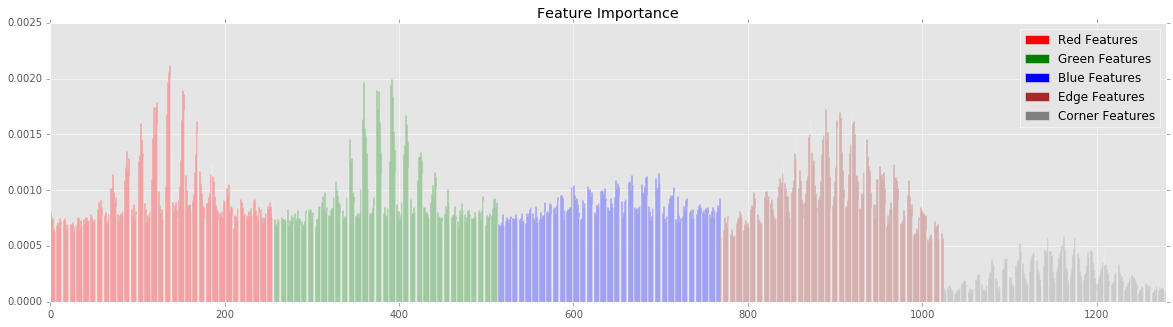

In [30]:
fig, ax = plt.subplots(figsize=(20,5))

num_red = final_red_features.shape[1]
num_green = final_green_features.shape[1]
num_blue = final_blue_features.shape[1]
num_edges = final_edge_features.shape[1]
num_corners = final_corner_features.shape[1]
x = [num_red, num_red + num_green, num_red + num_green + num_blue, num_red + num_green + num_blue + num_edges, num_red + num_green + num_blue + num_edges + num_corners]
ax.bar([i for i in range(x[0])], rf.feature_importances_[:x[0]], color='red', label='Red Features')
ax.bar([i for i in range(x[0], x[1])], rf.feature_importances_[x[0]:x[1]], color='green', label='Green Features')
ax.bar([i for i in range(x[1], x[2])], rf.feature_importances_[x[1]:x[2]], color='blue', label='Blue Features')
ax.bar([i for i in range(x[2], x[3])], rf.feature_importances_[x[2]:x[3]], color='brown', label='Edge Features')
ax.bar([i for i in range(x[3], x[4])], rf.feature_importances_[x[3]:x[4]], color='grey', label='Corner Features')
ax.set_title("Feature Importance")
ax.set_xlim(0,x[4])
ax.legend()
plt.show()

In [31]:
PCA_components = 50

In [32]:
red_pca = PCA(n_components=PCA_components)
red_pca.fit(final_red_features)
reduced_red_features = red_pca.transform(final_red_features)

In [33]:
green_pca = PCA(n_components=PCA_components)
green_pca.fit(final_green_features)
reduced_green_features = green_pca.transform(final_green_features)

In [34]:
blue_pca = PCA(n_components=PCA_components)
blue_pca.fit(final_blue_features)
reduced_blue_features = blue_pca.transform(final_blue_features)

In [35]:
edge_pca = PCA(n_components=PCA_components)
edge_pca.fit(final_edge_features)
reduced_edge_features = edge_pca.transform(final_edge_features)

In [36]:
corner_pca = PCA(n_components=PCA_components)
corner_pca.fit(final_corner_features)
reduced_corner_features = corner_pca.transform(final_corner_features)

In [37]:
reduced_features = np.concatenate((reduced_red_features, reduced_green_features, reduced_blue_features, reduced_edge_features, reduced_corner_features), axis=1)

In [38]:
#Setup grid-search for top parameters
depth = np.array([8, 10, 12, 14])
estimators = np.array([10, 25, 50, 100, 250, 500])
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=estimators, max_depth=depth))

In [39]:
grid.fit(reduced_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  25,  50, 100, 250, 500]), 'max_depth': array([ 8, 10, 12, 14])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [40]:
print("Best score = {}".format(grid.best_score_))
print("N_estimators: {}".format(grid.best_estimator_.n_estimators))
print("Max depth: {}".format(grid.best_estimator_.max_depth))

Best score = 0.296
N_estimators: 500
Max depth: 14


In [41]:
%%time
rf2 = RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, max_depth=grid.best_estimator_.max_depth)
rf2.fit(reduced_features, train_labels)

CPU times: user 56.7 s, sys: 171 ms, total: 56.8 s
Wall time: 56.9 s


In [42]:
reduced_red_t = red_pca.transform(final_red_t)
reduced_green_t = green_pca.transform(final_green_t)
reduced_blue_t = blue_pca.transform(final_blue_t)
reduced_edge_t = edge_pca.transform(final_edge_t)
reduced_corner_t = edge_pca.transform(final_corner_t)

In [43]:
reduced_test_features = np.concatenate((reduced_red_t, reduced_green_t, reduced_blue_t, reduced_edge_t, reduced_corner_t), axis=1)

In [44]:
%%time
predicted_labels = rf2.predict(reduced_test_features)

CPU times: user 582 ms, sys: 60.9 ms, total: 643 ms
Wall time: 392 ms


In [45]:
overall, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)

/Users/simonbedford/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/simonbedford/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/simonbedford/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
overall

,Accuracy,F1,Precision,Recall
Results,0.178,0.131,0.264,0.178


In [47]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.21,0.35,0.26,250.0
lasagna,0.17,0.00,0.01,250.0
french_toast,0.12,0.77,0.20,250.0
guacamole,0.37,0.04,0.07,250.0
apple_pie,0.00,0.00,0.00,250.0
cheesecake,0.32,0.36,0.34,250.0
hamburger,0.08,0.00,0.01,250.0
fried_rice,0.00,0.00,0.00,250.0
carrot_cake,1.00,0.00,0.01,250.0
chocolate_cake,0.30,0.25,0.27,250.0


In [48]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,87,0,92,0,0,4,1,0,0,17,47,2
lasagna,28,1,158,2,1,19,1,0,0,5,31,4
french_toast,23,0,193,1,0,4,0,0,0,3,22,4
guacamole,34,1,147,10,1,13,0,0,0,6,32,6
apple_pie,22,0,147,1,0,47,4,0,0,11,11,7
cheesecake,17,0,86,1,1,90,1,0,0,42,11,1
hamburger,30,0,155,1,1,18,1,0,0,16,28,0
fried_rice,21,3,181,6,1,16,0,0,0,5,7,10
carrot_cake,37,0,138,1,0,36,1,0,1,17,16,3
chocolate_cake,40,0,88,1,1,22,2,0,0,62,34,0


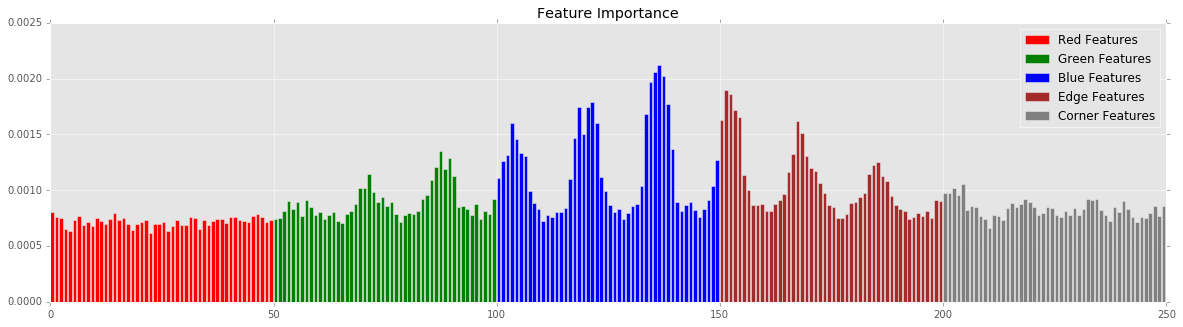

In [49]:
fig, ax = plt.subplots(figsize=(20,5))

num_red = reduced_red_features.shape[1]
num_green = reduced_green_features.shape[1]
num_blue = reduced_blue_features.shape[1]
num_edges = reduced_edge_features.shape[1]
num_corners = reduced_corner_features.shape[1]
x = [num_red, num_red + num_green, num_red + num_green + num_blue, num_red + num_green + num_blue + num_edges, num_red + num_green + num_blue + num_edges + num_corners]
ax.bar([i for i in range(x[0])], rf.feature_importances_[:x[0]], color='red', label='Red Features')
ax.bar([i for i in range(x[0], x[1])], rf.feature_importances_[x[0]:x[1]], color='green', label='Green Features')
ax.bar([i for i in range(x[1], x[2])], rf.feature_importances_[x[1]:x[2]], color='blue', label='Blue Features')
ax.bar([i for i in range(x[2], x[3])], rf.feature_importances_[x[2]:x[3]], color='brown', label='Edge Features')
ax.bar([i for i in range(x[3], x[4])], rf.feature_importances_[x[3]:x[4]], color='grey', label='Corner Features')
ax.set_title("Feature Importance")
ax.set_xlim(0,x[4])
ax.legend()
plt.show()

##### Optimized features based upon first classification attempt

In [50]:
N_features = 50

In [51]:
red_importances = rf.feature_importances_[:256]
green_importances = rf.feature_importances_[256:2*256]
blue_importances = rf.feature_importances_[2*256:3*256]
edge_importances = rf.feature_importances_[3*256:4*256]
corner_importances = rf.feature_importances_[4*256:5*256]

In [52]:
top_red_indices = np.argpartition(red_importances, N_features)[-1 * N_features:]
top_blue_indices = np.argpartition(blue_importances, N_features)[-1 * N_features:]
top_green_indices = np.argpartition(green_importances, N_features)[-1 * N_features:]
top_edge_indices = np.argpartition(edge_importances, N_features)[-1 * N_features:]
top_corner_indices = np.argpartition(corner_importances, N_features)[-1 * N_features:]

In [53]:
opt_red_features = final_red_features[:, top_red_indices]
opt_green_features = final_green_features[:, top_green_indices]
opt_blue_features = final_blue_features[:, top_blue_indices]
opt_edge_features = final_edge_features[:, top_edge_indices]
opt_corner_features = final_corner_features[:, top_corner_indices]

In [54]:
optimized_features = np.concatenate([opt_red_features, opt_green_features, opt_blue_features, opt_edge_features, opt_corner_features], axis=1)

In [55]:
#Setup grid-search for top parameters
depth = np.array([8, 10, 12, 14])
estimators = np.array([10, 25, 50, 100, 250, 500])
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=estimators, max_depth=depth))

In [56]:
grid.fit(optimized_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 10,  25,  50, 100, 250, 500]), 'max_depth': array([ 8, 10, 12, 14])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [57]:
print("Best score = {}".format(grid.best_score_))
print("N_estimators: {}".format(grid.best_estimator_.n_estimators))
print("Max depth: {}".format(grid.best_estimator_.max_depth))

Best score = 0.2831111111111111
N_estimators: 500
Max depth: 14


In [58]:
%%time
rf3 = RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, max_depth=grid.best_estimator_.max_depth)
rf3.fit(optimized_features, train_labels)

CPU times: user 43.4 s, sys: 266 ms, total: 43.6 s
Wall time: 43.9 s


In [59]:
opt_red_t = final_red_t[:, top_red_indices]
opt_green_t = final_green_t[:, top_green_indices]
opt_blue_t = final_blue_t[:, top_blue_indices]
opt_edge_t = final_edge_t[:, top_edge_indices]
opt_corner_t = final_edge_t[:, top_corner_indices]

In [60]:
optimized_test_features = np.concatenate([opt_red_t, opt_green_t, opt_blue_t, opt_edge_t, opt_corner_t], axis=1)

In [61]:
%%time
predicted_labels = rf3.predict(optimized_test_features)

CPU times: user 484 ms, sys: 68.8 ms, total: 553 ms
Wall time: 552 ms


In [62]:
overall, metrics, confusion = hc.get_metrics(test_labels, predicted_labels, class_list)

In [63]:
overall

,Accuracy,F1,Precision,Recall
Results,0.275,0.268,0.274,0.275


In [64]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.26,0.27,0.27,250.0
lasagna,0.22,0.24,0.23,250.0
french_toast,0.23,0.36,0.28,250.0
guacamole,0.27,0.30,0.29,250.0
apple_pie,0.21,0.10,0.14,250.0
cheesecake,0.33,0.40,0.36,250.0
hamburger,0.24,0.16,0.19,250.0
fried_rice,0.40,0.29,0.34,250.0
carrot_cake,0.22,0.11,0.15,250.0
chocolate_cake,0.33,0.36,0.34,250.0


In [65]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,68,25,25,12,2,12,7,4,3,28,53,11
lasagna,22,59,29,17,13,19,17,22,5,2,21,24
french_toast,18,25,90,18,7,10,11,5,9,17,18,22
guacamole,14,17,17,75,15,13,22,23,11,7,18,18
apple_pie,19,23,34,22,26,39,20,15,12,11,9,20
cheesecake,11,9,20,16,11,100,10,3,18,41,5,6
hamburger,20,28,27,20,12,11,41,12,12,17,34,16
fried_rice,8,33,16,37,8,11,10,73,6,3,13,32
carrot_cake,26,11,43,11,19,36,13,5,28,16,30,12
chocolate_cake,13,1,30,10,3,35,5,3,15,90,38,7


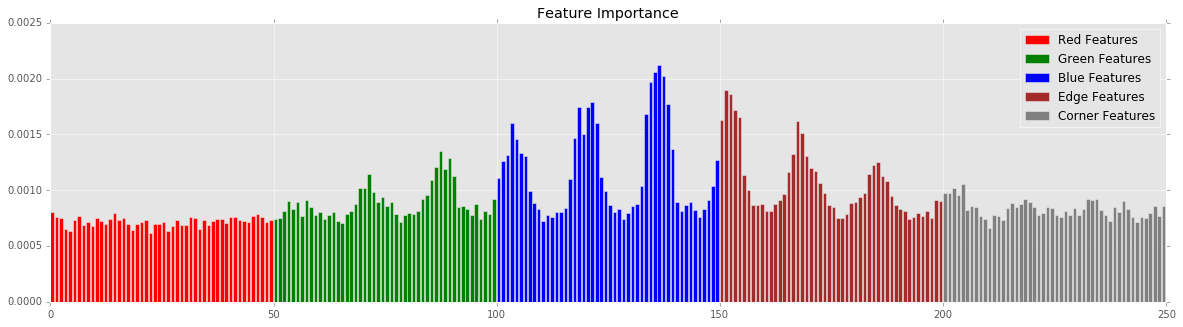

In [66]:
fig, ax = plt.subplots(figsize=(20,5))

num_red = opt_red_features.shape[1]
num_green = opt_green_features.shape[1]
num_blue = opt_blue_features.shape[1]
num_edges = opt_edge_features.shape[1]
num_corners = opt_corner_features.shape[1]
x = [num_red, num_red + num_green, num_red + num_green + num_blue, num_red + num_green + num_blue + num_edges, num_red + num_green + num_blue + num_edges + num_corners]
ax.bar([i for i in range(x[0])], rf.feature_importances_[:x[0]], color='red', label='Red Features')
ax.bar([i for i in range(x[0], x[1])], rf.feature_importances_[x[0]:x[1]], color='green', label='Green Features')
ax.bar([i for i in range(x[1], x[2])], rf.feature_importances_[x[1]:x[2]], color='blue', label='Blue Features')
ax.bar([i for i in range(x[2], x[3])], rf.feature_importances_[x[2]:x[3]], color='brown', label='Edge Features')
ax.bar([i for i in range(x[3], x[4])], rf.feature_importances_[x[3]:x[4]], color='grey', label='Corner Features')
ax.set_title("Feature Importance")
ax.set_xlim(0,x[4])
ax.legend()
plt.show()